# Simpson's caracters classification task

## 0. Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [24]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [27]:
! kaggle datasets download -d 'alexattia/the-simpsons-characters-dataset'

 99% 1.07G/1.08G [00:15<00:00, 63.2MB/s]
100% 1.08G/1.08G [00:15<00:00, 76.1MB/s]


In [ ]:
! mkdir datasets
! unzip the-simpsons-characters-dataset.zip -d datasets

## 1. Data preprocessing and visualization<a class="anchor" id="1"></a>

### Make united dataframe

In [29]:
def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    return df

train_dir = Path('/content/datasets/simpsons_dataset/')
filepaths = list(train_dir.glob(r'**/*.jpg'))
df = proc_img(filepaths)


NUM_CLASSES = len(df.Label.unique())
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {NUM_CLASSES}\n')
df.head(5)

Number of pictures: 41866

Number of different labels: 42



,Filepath,Label
0,/content/datasets/simpsons_dataset/lisa_simpso...,lisa_simpson
1,/content/datasets/simpsons_dataset/simpsons_da...,kent_brockman
2,/content/datasets/simpsons_dataset/simpsons_da...,marge_simpson
3,/content/datasets/simpsons_dataset/simpsons_da...,moe_szyslak
4,/content/datasets/simpsons_dataset/bart_simpso...,bart_simpson


### Visualisation original images



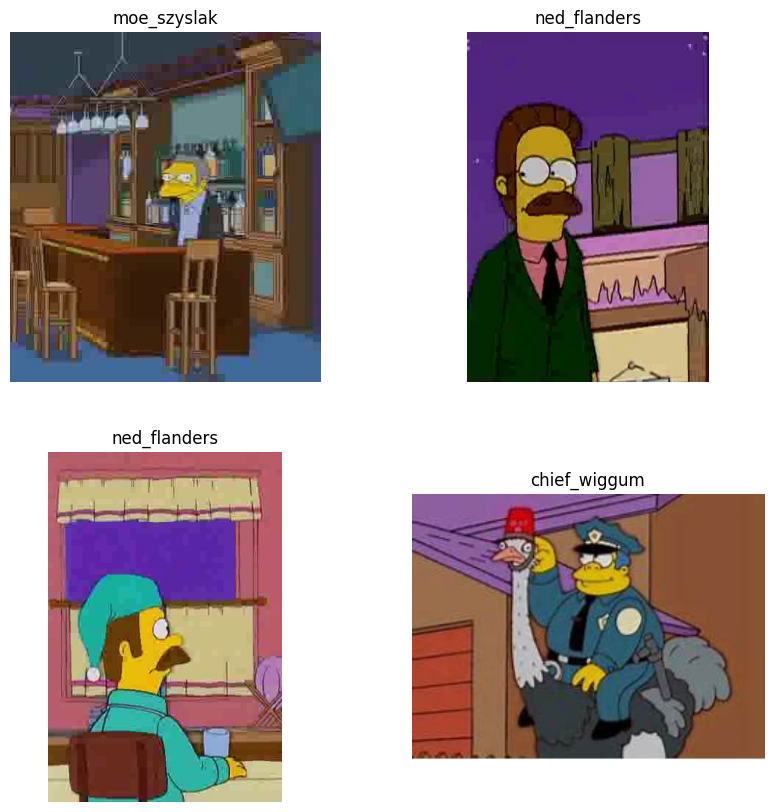

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i])
    ax.axis("off")

plt.show()

## 2. Prepare images and split on train, valid and test

### Prepare and Augmentation data for model

In [30]:
def prepare_data(input_size):
    dir = '/content/datasets/simpsons_dataset'
    filepaths = list(Path(dir).glob(r'**/*.jpg'))


    train_data_generator = ImageDataGenerator(validation_split=0.2,
                            preprocessing_function=preprocess_input,
                            rotation_range=30,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

    train_data = train_data_generator.flow_from_dataframe(
                                train_df,
                                x_col='Filepath',
                                y_col='Label',
                                target_size=input_size,
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=32,
                                shuffle=True,
                                seed=0,
                                subset='training')

    valid_data = train_data_generator.flow_from_dataframe(
                                train_df,
                                x_col='Filepath',
                                y_col='Label',
                                target_size=input_size,
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=32,
                                shuffle=True,
                                seed=0,
                                subset='validation')


    test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_data = test_data_generator.flow_from_dataframe(
                                dataframe=test_df,
                                x_col='Filepath',
                                y_col='Label',
                                target_size=input_size,
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=32,
                                shuffle=False)

    labels = train_data.labels
    file_names = train_data.filenames
    gen_length = len(labels)
    class_dict = train_data.class_indices
    new_class_dict = {}
    for key,value in class_dict.items(): # reverse the dictionary show it is in the form {integer label, class_name}
        new_class_dict[value] = key
    print()
    print("Classes:")
    for x in new_class_dict:
        print(x,":", new_class_dict[x])

    return train_data, valid_data, test_data, new_class_dict

### Split data

In [31]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

In [32]:
INPUT_SIZE = (224, 224)
train_images, val_images, test_images, class_names = prepare_data(INPUT_SIZE)

Found 26794 validated image filenames belonging to 42 classes.
Found 6698 validated image filenames belonging to 42 classes.
Found 8374 validated image filenames belonging to 41 classes.

Classes:
0 : abraham_grampa_simpson
1 : agnes_skinner
2 : apu_nahasapeemapetilon
3 : barney_gumble
4 : bart_simpson
5 : carl_carlson
6 : charles_montgomery_burns
7 : chief_wiggum
8 : cletus_spuckler
9 : comic_book_guy
10 : disco_stu
11 : edna_krabappel
12 : fat_tony
13 : gil
14 : groundskeeper_willie
15 : homer_simpson
16 : kent_brockman
17 : krusty_the_clown
18 : lenny_leonard
19 : lionel_hutz
20 : lisa_simpson
21 : maggie_simpson
22 : marge_simpson
23 : martin_prince
24 : mayor_quimby
25 : milhouse_van_houten
26 : miss_hoover
27 : moe_szyslak
28 : ned_flanders
29 : nelson_muntz
30 : otto_mann
31 : patty_bouvier
32 : principal_skinner
33 : professor_john_frink
34 : rainier_wolfcastle
35 : ralph_wiggum
36 : selma_bouvier
37 : sideshow_bob
38 : sideshow_mel
39 : snake_jailbird
40 : troy_mcclure
41 : wa

### Plot train distribution

In [13]:
def plot_class_distribution(train_data,class_names):
    train_labels = train_data.labels
    train_counts = np.bincount(train_labels)

    fig, ax1 = plt.subplots(1,1, figsize=(7, 7))
    ax1.bar(class_names, train_counts, color='skyblue', alpha=0.5)
    ax1.set_title('Training Data')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show();


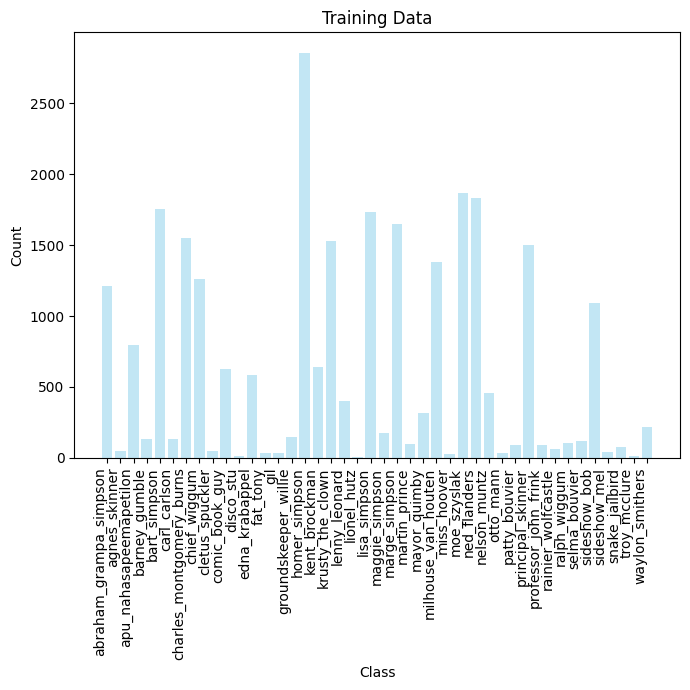

In [14]:
plot_class_distribution(train_images, class_names.values())

### Plot data after VGG16 preparation


In [15]:
def plot_img(datagen_flow, class_names):
    features, labels = next(datagen_flow)
    fig = plt.figure(figsize=(5, 5))
    for i in range(4):
        fig.add_subplot(2, 2, i + 1)
        img = features[i]
        img = (img * 255).astype(np.uint8)
        img = np.clip(img, 0, 255)
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()


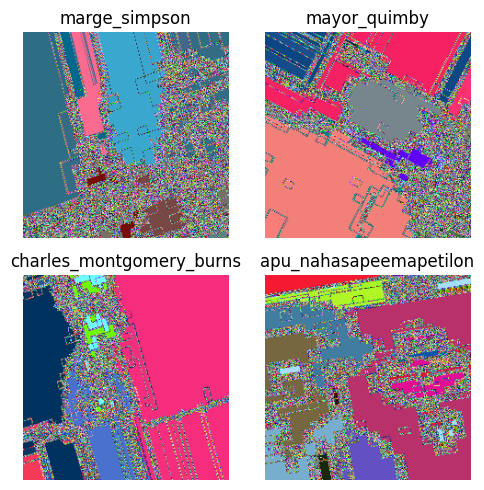

In [16]:
plot_img(train_images, class_names=class_names)

## 3. Train the model<a class="anchor" id="3"></a>


In [20]:
def create_model(fine_tune_layers=0):
    base_model = VGG16(
                input_shape=(224, 224, 3),
                include_top=False,
                weights='imagenet',
                pooling='avg')
    base_model.trainable = False

    num_layers = len(base_model.layers)
    for layer in base_model.layers[num_layers-fine_tune_layers:]:
        layer.trainable = True

    inputs = base_model.input
    x = Dense(128, activation='relu')(base_model.output)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(42, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [18]:
device = tf.device('/device:GPU:0')
with device:
  model = create_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [2]:
from google.colab import drive
drive.mount ('/drive')

Mounted at /drive


In [20]:
checkpoint_filepath = '/drive/MyDrive/checkpoints'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=5,
                                restore_best_weights=True)

In [21]:
with device:
  history = model.fit(train_images,
                        validation_data=val_images,
                        epochs=20,
                        callbacks=[model_checkpoint_callback,
                                   early_stopping_callback])

Epoch 1/20
838/838 [==============================] - 555s 649ms/step - loss: 2.0987 - accuracy: 0.4459 - val_loss: 1.5963 - val_accuracy: 0.5787
Epoch 2/20
838/838 [==============================] - 500s 597ms/step - loss: 1.4185 - accuracy: 0.6189 - val_loss: 1.3503 - val_accuracy: 0.6335
Epoch 3/20
838/838 [==============================] - 497s 593ms/step - loss: 1.2689 - accuracy: 0.6503 - val_loss: 1.2507 - val_accuracy: 0.6569
Epoch 4/20
838/838 [==============================] - 497s 593ms/step - loss: 1.1671 - accuracy: 0.6763 - val_loss: 1.2220 - val_accuracy: 0.6600
Epoch 5/20
838/838 [==============================] - 501s 598ms/step - loss: 1.0990 - accuracy: 0.6877 - val_loss: 1.1900 - val_accuracy: 0.6677
Epoch 6/20
838/838 [==============================] - 547s 653ms/step - loss: 1.0523 - accuracy: 0.7019 - val_loss: 1.1399 - val_accuracy: 0.6832
Epoch 7/20
838/838 [==============================] - 498s 594ms/step - loss: 1.0091 - accuracy: 0.7132 - val_loss: 1.1506 -

T4 GPU train time: 2h 54m

### Plot train Accuracy and Loss

In [ ]:
acc_df = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
loss_df = pd.DataFrame(history.history)[['loss','val_loss']]
acc_df.to_csv('/drive/MyDrive/acc_df.csv')
loss_df.to_csv('/drive/MyDrive/loss_df.csv')

In [13]:
def plot_train_params(acc_df, loss_df):
  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 8))

  acc_df.plot(ax=ax1)
  ax1.set_title("Accuracy")
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.grid(True)

  loss_df.plot(ax=ax2)
  ax2.set_title("Loss")
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.grid(True)

  plt.show()

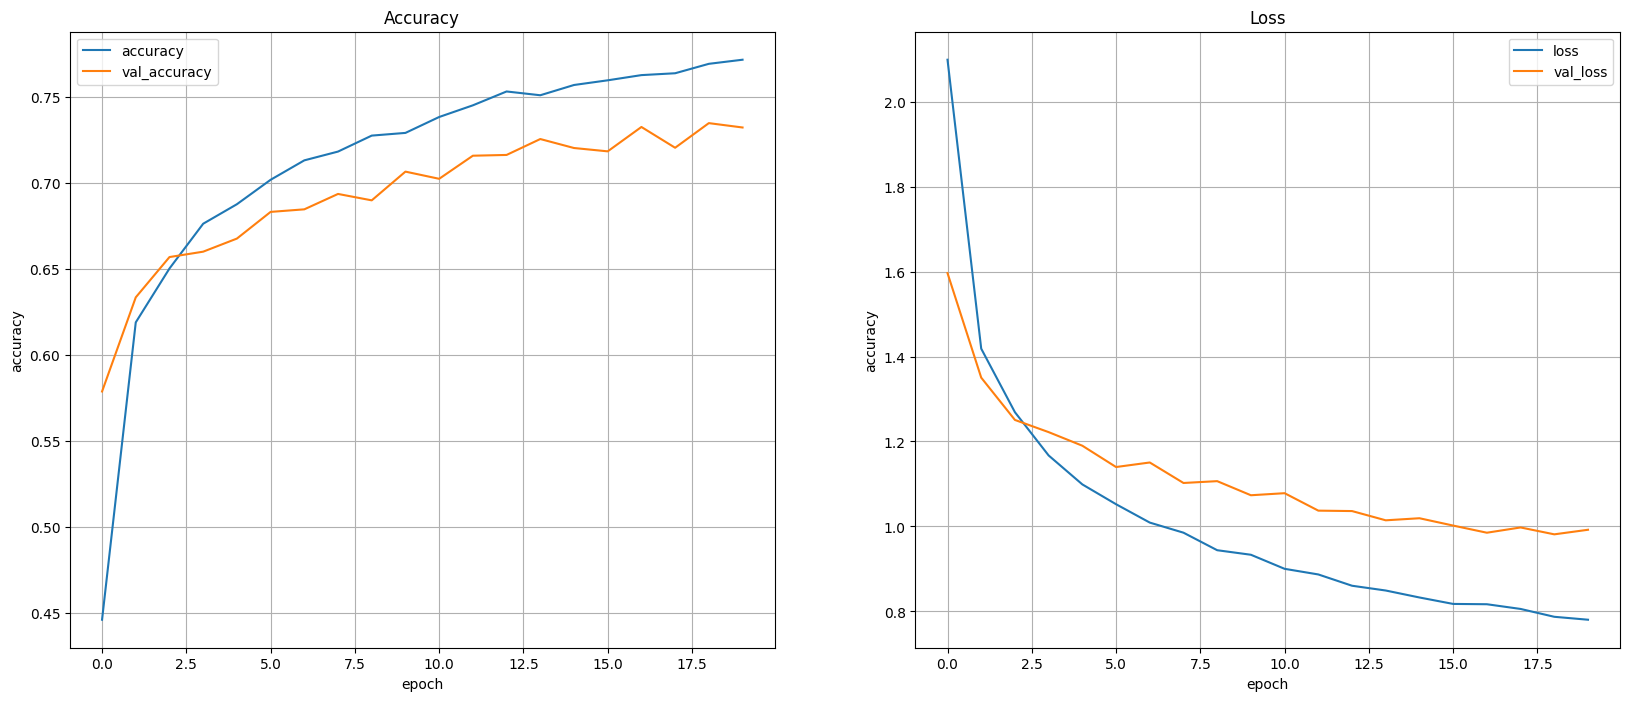

In [14]:
acc_df = pd.read_csv('/drive/MyDrive/acc_df.csv').drop(columns=['Unnamed: 0'])
loss_df = pd.read_csv('/drive/MyDrive/loss_df.csv').drop(columns=['Unnamed: 0'])
plot_train_params(acc_df, loss_df)

### Save model weights

In [24]:
# model.save_weights('/drive/MyDrive/')

In [21]:
model = create_model()
model.load_weights('/drive/MyDrive/')
# loss, acc = model.evaluate(test_images, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

## 4. Visualize the result<a class="anchor" id="4"></a>

### Prediction visualization

In [33]:
predictions = model.predict(test_images)

262/262 [==============================] - 46s 135ms/step


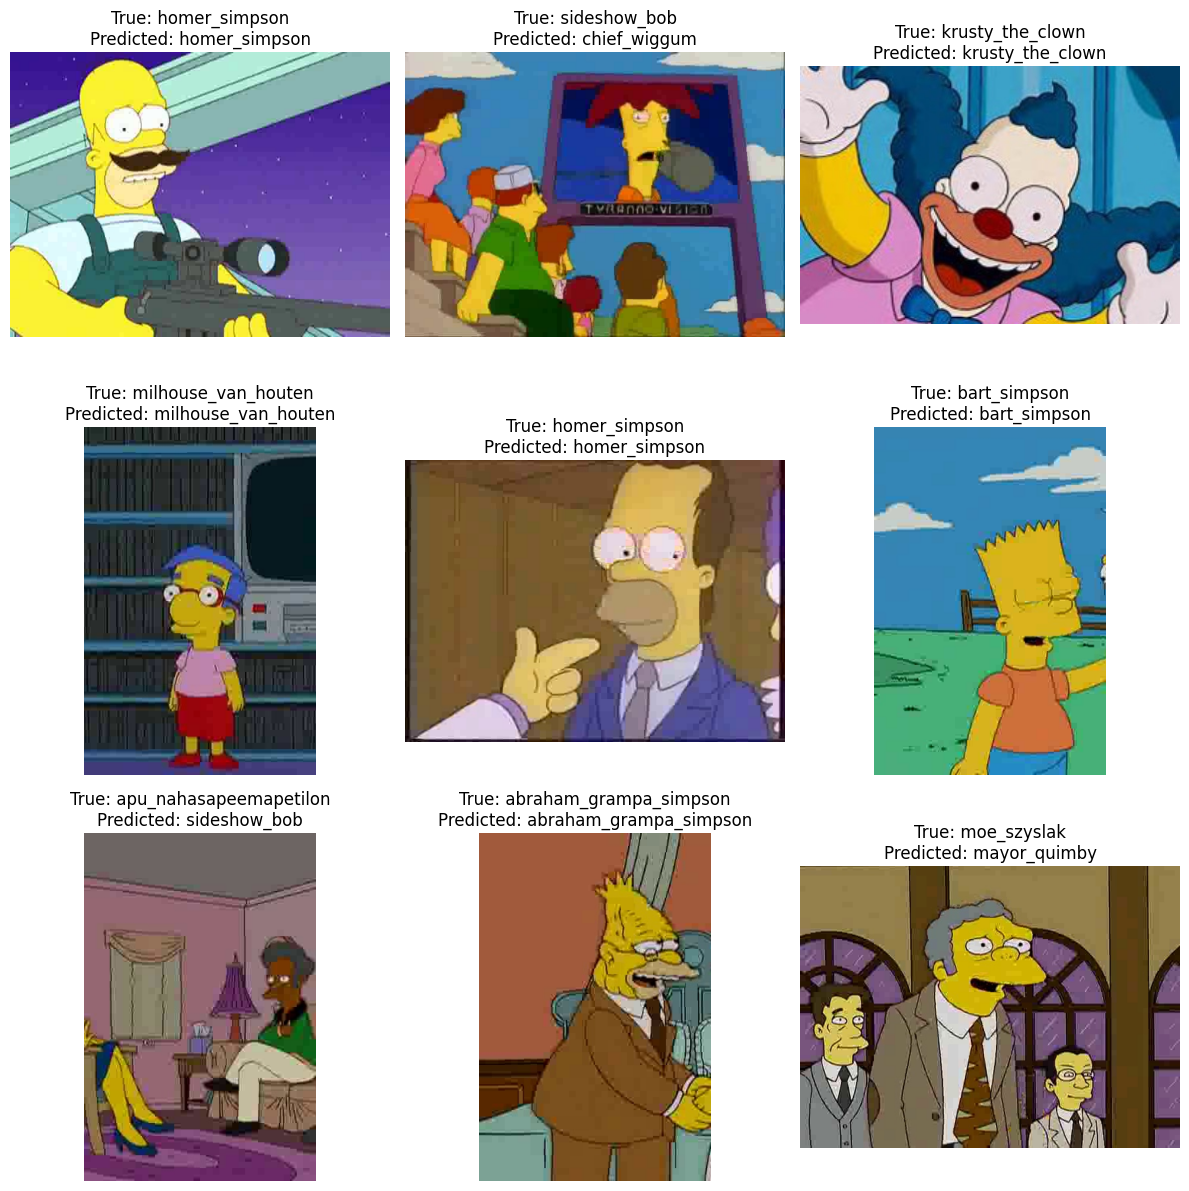

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    pred_label = class_names[np.argmax(predictions[i])]
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred_label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Difficult classification examples

In [35]:
ground_truth = test_images.classes
pred = np.argmax(predictions, axis=1)

mask = ground_truth == pred

In [36]:
x_false = test_df['Filepath'][~mask]
y_false = test_df['Label'][~mask]
p_false = pred[~mask]

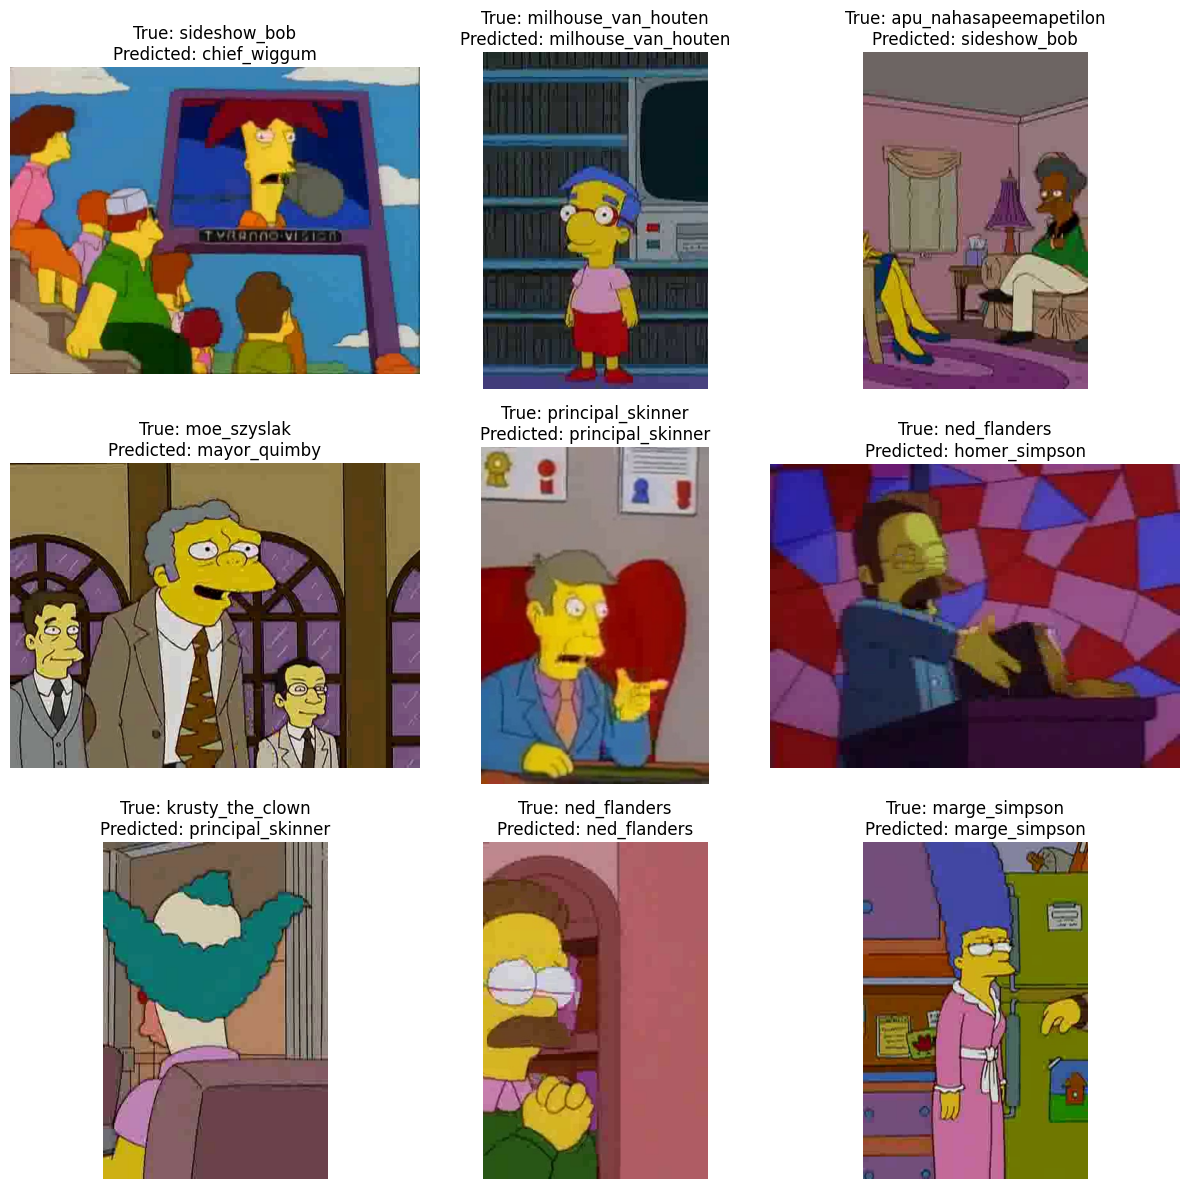

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(x_false.iloc[i]))
    ax.set_title(f"True: {y_false.iloc[i]}\nPredicted: {class_names[p_false[i]]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Count false predictions by classes

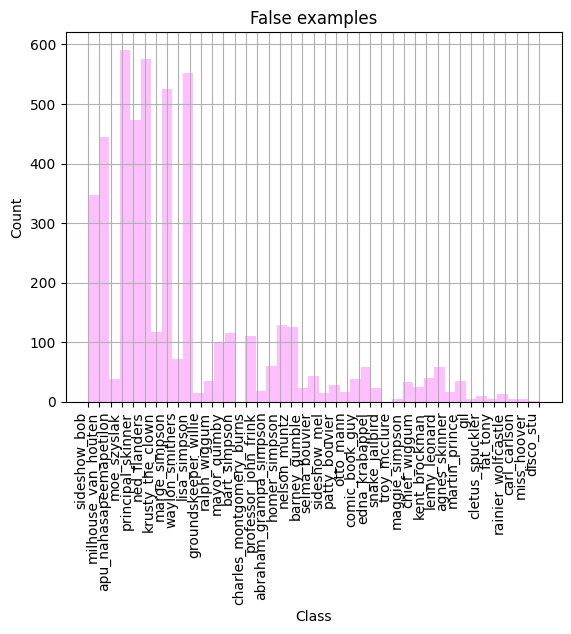

In [41]:
y_false.hist(bins=43,color='magenta', alpha=0.25)
plt.title('False examples')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.show();
